# Prototype Workflow: V2

This differs from the previous version in that it uses a pure numpy array regridding feature in the `xESMF` library since WRF's grids are on a curvilinear grid.

## 1. Setup Environment

In [1]:
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np

# The source grid is from the month of October 1986 (i.e., the first month of the water year)
src_grid = 'debug_grid_data/livneh_NAmerExt_15Oct2014.198610.nc'

# The destination grid is a geo_em file from a 30-year WRF run in Idaho forced by NARR data. 
# The geo_em file has been renamed to distinguish it from other geo_em files from other WRF runs.
dest_grid = 'dest/id_wrf_narr_d01.nc'


## 2. Load the Source Data

Load the Livneh data as an `xArray` dataset and plot October 29 when some precipitation occurs in the region of interest

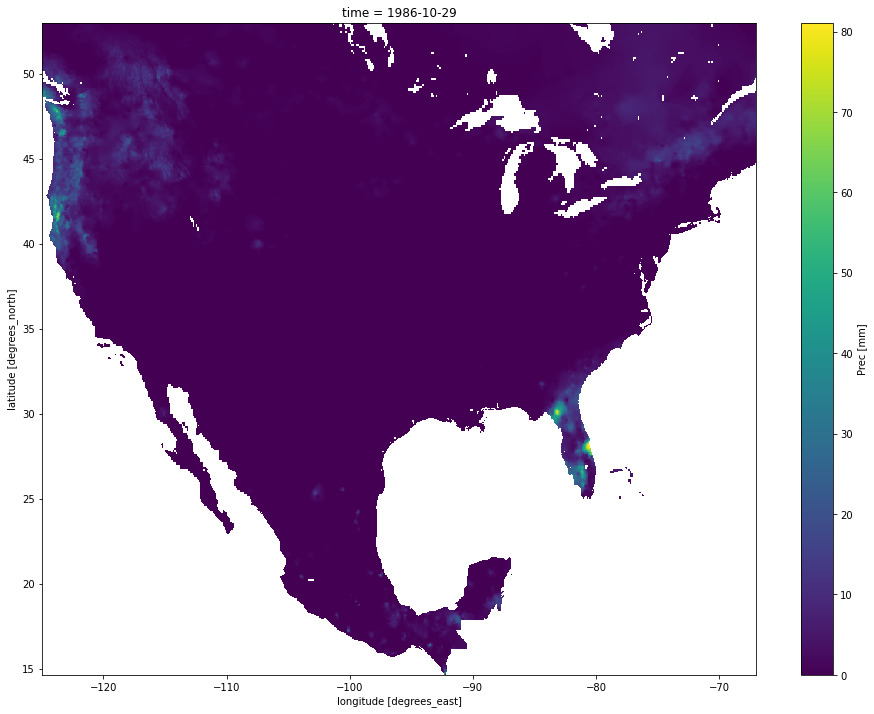

In [2]:
ds_src = xr.open_dataset(src_grid)
ds_src['Prec'][28].plot(figsize=(16,12))

## 3. Set Source Grid Centers and Boundaries

`xESMF`'s conservative regridding option requires the location of both the grid centers and the corners. Since the Livneh data is on a rectilinear grid, this is fairly straight forward. The coordinate arrays `lon` and `lat` are 1-D arrays with the longitude and latitude, respectively, of the cell centers. To get the corners, all we need to do is append the first cell minus 1/2 the spatial resolution (inferred by subtracting) to the rest of the longitude/latitude values plus 1/2 the spatial resolution. 

We then pass these arrays to `np.meshgrid()` to get the cell center and corner latitude and longitude as 2-D arrays. This is necessary since our destination grid – from WRF – is on a curvilinear, rather than rectilinear, grid

In [3]:
src_lon = ds_src['lon'].data
src_lat = ds_src['lat'].data
src_lon_b = np.append((src_lon[0]-0.5*(src_lon[1]-src_lon[0])),(src_lon+0.5*(src_lon[1]-src_lon[0])))
src_lat_b = np.append((src_lat[0]-0.5*(src_lat[1]-src_lat[0])),(src_lat+0.5*(src_lat[1]-src_lat[0])))

src_lon, src_lat = np.meshgrid(src_lon,src_lat)
src_lon_b, src_lat_b = np.meshgrid(src_lon_b,src_lat_b)


## 4. Open the Destination Grid

We're loading the WRF geo_em file into an `xArray` dataset, dropping dimensions (and therefore variables) that are not of interest. The geo_em files contain a lot of additional information that is not pertinent to developing a regridder. 

In [4]:
ds_dest = xr.open_dataset(dest_grid)
ds_dest = ds_dest.drop_dims(('land_cat','soil_cat','month','num_urb_params'))
print(ds_dest)

<xarray.Dataset>
Dimensions:     (Time: 1, south_north: 289, west_east: 339, south_north_stag: 290, west_east_stag: 340)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag, west_east_stag
Data variables: (12/50)
    Times       (Time) |S19 ...
    XLAT_M      (Time, south_north, west_east) float32 ...
    XLONG_M     (Time, south_north, west_east) float32 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 ...
    ...          ...
    OL3         (Time, south_north, west_east) float32 ...
    OL4         (Time, south_north, west_east) float32 ...
    VAR_SSO     (Time, south_north, west_east) float32 ...
    LAKE_DEPTH  (Time, south_north, west_east) float32 ...
    IMPERV      (Time, south_north, west_east) float32 ...
    CANFRA      (Time, south_north, west_east) float32 ...
Attributes: (12/47)
    TITLE:             

## 5. Set Destination Grid Centers and Boundaries

In this case, we are very fortunate that the geo_em file provides the latitude and longitude for both the cell centers and boundaries. The latitude and longitude for cell centers is stored in `XLAT_M` and `XLONG_M`, respectively. The latitude and longitude of cell corners is stored in `XLAT_C` and `XLONG_C`, respectively. So we need only retrieve the data 

In [5]:
dest_lat = ds_dest['XLAT_M'][0].data
dest_lon = ds_dest['XLONG_M'][0].data

dest_lat_b = ds_dest['XLAT_C'][0].data
dest_lon_b = ds_dest['XLONG_C'][0].data

## 6. Prepare Dictionaries of the Source and Destination Grids

In [6]:
grid_src = {'lon': src_lon, 'lat': src_lat,
            'lon_b': src_lon_b, 'lat_b': src_lat_b}

grid_dest = {'lon': dest_lon, 'lat': dest_lat,
             'lon_b': dest_lon_b, 'lat_b': dest_lat_b}

## 7. Call the `xESMF` `Regridder` function with the 'conservative' option 

In [7]:
regridder = xe.Regridder(grid_src, grid_dest, 'conservative')
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_614x928_289x339.nc 
Reuse pre-computed weights? False 
Input grid shape:           (614, 928) 
Output grid shape:          (289, 339) 
Periodic in longitude?      False

## 8. Check Results

We will get the precipitation on October 29 as an `xArray` dataArray.

In [8]:
dr = ds_src['Prec'][28]
print(dr)

<xarray.DataArray 'Prec' (lat: 614, lon: 928)>
[569792 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 ... -67.16 -67.09 -67.03
  * lat      (lat) float64 14.66 14.72 14.78 14.84 ... 52.78 52.84 52.91 52.97
    time     datetime64[ns] 1986-10-29
Attributes:
    units:     mm
    longname:  Precipitation


### 8a. Pass the data array to the regridder

In [9]:
dr_dest = regridder(dr)

/Users/lejoflores/miniconda3/envs/xregridhydromet/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('lat', 'lon') from data variable Prec as the horizontal dimensions for the regridding.
  warnings.warn(


### 8b. Plot the results

They look reasonable. To the eye I can identify the Blue/Wallowa Mountains, the Central Idaho Rockies and the Tetons. Note that the Great Salt Lake shows up as `NaN` data.

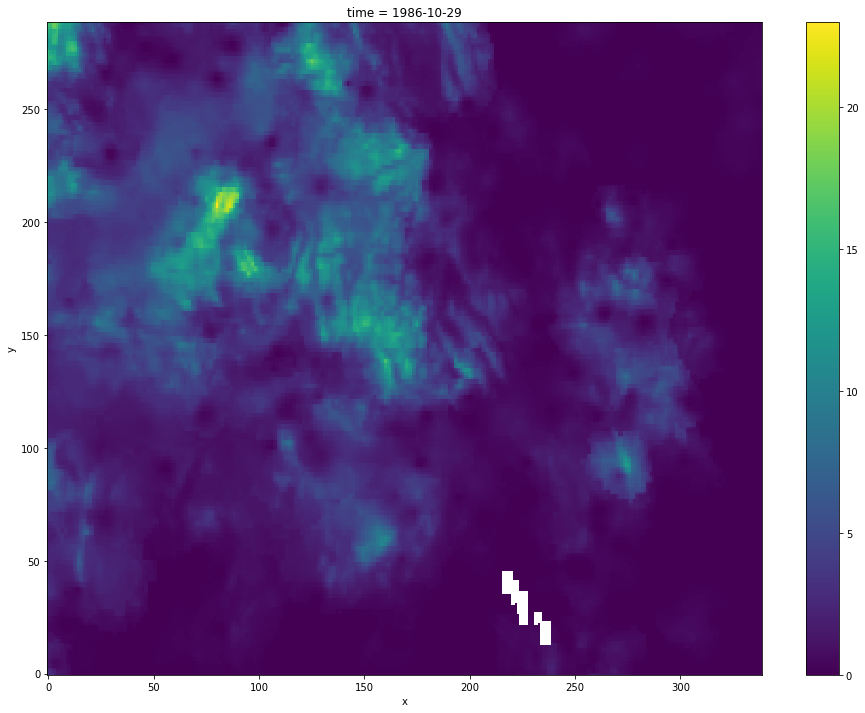

In [10]:
dr_dest.plot(figsize=(16,12))

## 9. Save Regridder for Future Use

The regridder is simply a sparse matrix of weights that multiplies the values in the source grid times a weight to produce the destination grid. As such it can be saved as a NetCDF file for later use. Note that when regridding large amounts of data this is wise because constructing the regridder is complex, whereas the actual regridding is just a matrix multiplication.  

In [11]:
regridder.to_netcdf()

'conservative_614x928_289x339.nc'